# Table of Contents <a id = 'scrollTo=8ZHYR1PYhOvg'></a>

>[Table of Contents](#scrollTo=8ZHYR1PYhOvg)

>>[Introduction](#scrollTo=WJAjUmtVDPhy)
>>>[Import Packages](#scrollTo=6bPDSyZmoGl4)<br>
>>>[Import Data](#scrollTo=f6iVCKMtoAAw)<br>

>>[Data Preparation](#scrollTo=wdZW3n2bPhd-)<br>
>>>[Data feature generation & conversion](#scrollTo=wdZW3n2bPhd-)<br>
>>>[Missing Values](#missing)<br>
>>>[Cross Validation](#cross)<br>
>>>[Hyperparameter Tuning](#hyper)<br>

>[Conclusion](#Conclusion) <br>

# Introduction <a id = "scrollTo=WJAjUmtVDPhy"></a>

Our objective in this modeling project is to perform survival analysis on maintenance events within an industrial setting, focusing on the time-to-failure and replacement patterns for key equipment components. By analyzing maintenance logs, we aim to identify trends, frequent failure points, and critical functional locations that require frequent interventions, which could inform future predictive maintenance strategies and improve operational efficiency.
Our analytical approach involves several key steps:

- **Data Preprocessing:** We begin by filtering and cleaning the dataset, focusing specifically on unplanned maintenance events and high-frequency parts, such as fillers and valves. This allows us to concentrate on the components that contribute most significantly to operational interruptions.
- **Feature Engineering:** For each maintenance event, we calculate the time-to-event (days between consecutive replacements or failures) and use it as our primary variable of interest in the survival analysis.
- **Regression Modeling:** The regression model predicts intervals between machine breakdowns using features from the California Housing Prices dataset. Techniques like Ridge, Lasso, and ElasticNet were applied to handle multicollinearity, enabling proactive maintenance scheduling and actionable insights for reducing downtime.
- **Cross-validation and Hyperparameter:** Cross-validation and Hyperparameter tuning ensured model robustness and optimal performance. By testing on multiple folds, we minimized overfitting, while grid search fine-tuned parameters like regularization strength, enhancing predictive accuracy and generalizability.








## Import Packages <a id = 'scrollTo=6bPDSyZmoGl4'></a>

In [50]:
# Import necessary packages
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


## Import Data <a id = 'scrollTo=f6iVCKMtoAAw'></a>

In [51]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv')

# Data Preparation <a id = 'scrollTo=wdZW3n2bPhd-'></a>

### Data feature generation & conversion <a id = 'scrollTo=wdZW3n2bPhd-'></a>

In [52]:
# Convert numeric data to date type data
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
df['EXECUTION_FINISH_DATE'] = pd.to_datetime(df['EXECUTION_FINISH_DATE'])
df['EQUIP_START_UP_DATE'] = pd.to_datetime(df['EQUIP_START_UP_DATE'])
df['EQUIP_VALID_FROM'] = pd.to_datetime(df['EQUIP_VALID_FROM'])

In [53]:
# Calculate functional duration
df['FUNCTIONAL_DURATION'] =  df['EXECUTION_START_DATE'] - df['EQUIP_VALID_FROM']

This column measures the time between when a machine started being functional (EQUIP_VALID_FROM) and each breakdown’s start date. This metric provides insight into how long each machine typically operates before issues arise, helping to quantify the effect of wear and tear on operational stability.

In [54]:
df.sample(50)

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,FUNCTIONAL_DURATION
243133,170000457709,G261,SILVERSTONE,2018-10-07,2018-10-07,22:10:00.000,22:25:00.000,15.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
1050389,613040573,G261,SILVERSTONE,2023-11-14,2023-11-14,08:36:57.000,10:21:34.000,102.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
555200,701923905,G811,MONACO,2020-01-06,2020-01-06,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
589515,601109232,G261,SILVERSTONE,2019-01-30,2019-01-31,07:36:50.000,14:32:40.000,60.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
1327268,1001479733,G291,MONZA,2021-10-26,2021-10-26,00:00:00.000,00:00:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
1005668,902102849,G261,SILVERSTONE,2024-08-09,2024-08-09,12:53:00.000,16:52:00.000,2.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
79645,202890842,G261,SILVERSTONE,2018-11-29,2018-11-30,00:13:00.000,23:51:00.000,88.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
722255,170002017171,G261,SILVERSTONE,2023-09-22,2023-09-22,21:00:00.000,22:00:00.000,60.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
596744,1001079545,G811,MONACO,2020-09-16,2020-09-16,00:00:00.000,00:00:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
356967,703823301,G221,SUZUKA,2022-07-28,2022-07-28,07:00:00.000,07:00:00.000,30.0,G221VJ1179,90567.0,Planned,CONV FULLCASE M19 TO PALL FOR MECH WHILE,Preventive Maintenance Order,G221-PRD-L15-L04-L030,SUZUKA PRODUCTION,L4 - FILLER_ROTARY_CAN,LINE #4-FILLER_ROTARY_CAN,CONVEYOR,NaN,300009155.0,NaN,NaN,NaT,NaT,NaN,NaT


In [55]:
# Functional location code split
df['FUCTIONAL_LOC_SPLIT'] = df['FUNCTIONAL_LOC'].str.split('-')

In [56]:
# Select all date columns
date_columns = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE','EQUIP_VALID_FROM']  # replace with actual column names
 
# Stack them into a single series
all_dates = df[date_columns].stack()
 
# Find the latest date
latest_date = all_dates.max()
 
print("The latest date in the dataset is:", latest_date)

The latest date in the dataset is: 2024-08-30 00:00:00


### Missing Values <a id = 'missing'></a>

In [57]:
# Check for missing values
df.isnull().sum() / len(df) * 100

ORDER_ID                            0.000000
PLANT_ID                            0.000000
PRODUCTION_LOCATION                 0.000000
EXECUTION_START_DATE                0.000000
EXECUTION_FINISH_DATE               0.000000
ACTUAL_START_TIME                   0.000000
ACTUAL_FINISH_TIME                  0.000000
ACTUAL_WORK_IN_MINUTES              0.000000
MAINTENANCE_PLAN                   89.308635
MAINTENANCE_ITEM                   89.308635
MAINTENANCE_ACTIVITY_TYPE           0.000000
ORDER_DESCRIPTION                  79.557601
MAINTENANCE_TYPE_DESCRIPTION       79.555639
FUNCTIONAL_LOC                     79.556550
FUNCTIONAL_AREA_NODE_1_MODIFIED    79.673207
FUNCTIONAL_AREA_NODE_2_MODIFIED    80.213401
FUNCTIONAL_AREA_NODE_3_MODIFIED    81.875042
FUNCTIONAL_AREA_NODE_4_MODIFIED    83.354656
FUNCTIONAL_AREA_NODE_5_MODIFIED    99.847260
EQUIPMENT_ID                       79.555639
EQUIPMENT_DESC                     94.433616
EQUIP_CAT_DESC                     94.433616
EQUIP_STAR

Missing value analysis indicates that the column with the highest percentage of missing data is 'FUNCTIONAL_AREA_NODE_5_MODIFIED' (99.8%), followed by 'EQUIPMENT_DESC' and 'EQUIP_START_UP_DATE' (both at 94.4%). These columns contain the most significant gaps, which may impact the comprehensiveness of our analysis in these areas


In [58]:
# Isolate breakdowns by PLANT_ID, LINE_ID, and SUBPROCESS_ID
df['PLANT_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[0]
df['LINE_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[2]
df['SUBPROCESS_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[3]

# Create a machine id which is a combination of all three, here the machine id is the functional location 
df['MACHINE_ID'] = df['PLANT_ID'] + '-' + df['LINE_ID'] + '-' + df['SUBPROCESS_ID']

By isolating breakdowns by PLANT_ID, LINE_ID, and SUBPROCESS_ID, we can identify specific areas within a plant that may require more maintenance or have a higher frequency of issues. This breakdown enables focused interventions at locations with recurrent breakdowns, supporting predictive and preventive maintenance.<br>The Machine ID are not unique identifiers for Machine but says the functional location.

In [59]:
# Calculate machine level aggregations
df_ml = df.groupby('MACHINE_ID').agg(
                             PLANT_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_1_MODIFIED", aggfunc="first"),
                             LINE_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_3_MODIFIED", aggfunc="first"),
                             SUBPROCESS_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_4_MODIFIED", aggfunc="first"),
                             FIRST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc="min"),
                             SECOND_LAST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc= lambda x: x.sort_values().iloc[-2] if len(x) >= 2 else pd.NaT),
                             LAST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc="max"),
                             FIRST_BREAK_DURATION = pd.NamedAgg(column="FUNCTIONAL_DURATION", aggfunc="max"),
                             TOTAL_WORKING_MINUTES = pd.NamedAgg(column="ACTUAL_WORK_IN_MINUTES", aggfunc="sum"),
                             BREAKDOWN_COUNT =pd.NamedAgg(column="ORDER_ID", aggfunc="count"),
                             PLANNED_COUNT = pd.NamedAgg(column="MAINTENANCE_PLAN", aggfunc = "count")).reset_index()

In [60]:
# Calculate other features and target variable
df_ml = df_ml.assign(UNPLANNED_COUNT = df_ml['BREAKDOWN_COUNT'] - df_ml['PLANNED_COUNT'],
                     TOTAL_RUNNUNG_DURATION = df_ml['SECOND_LAST_BREAKDOWN'] - df_ml['FIRST_BREAKDOWN'],
                     TARGET = df_ml['LAST_BREAKDOWN'] - df_ml['SECOND_LAST_BREAKDOWN'])

Aggregating by MACHINE_ID helps capture machine-specific downtime patterns and maintenance needs. Key metrics like TOTAL_WORKING_MINUTES and UNPLANNED_COUNT help identify which machines are most prone to unexpected breakdowns. TOTAL_RUNNING_DURATION provides historical uptime, which helps predict downtime intervals. The TARGET variable quantifies breakdown intervals, enabling predictive modeling for proactive maintenance scheduling.

In [61]:
df_ml.sample(30)

,MACHINE_ID,PLANT_ID,LINE_ID,SUBPROCESS_ID,FIRST_BREAKDOWN,SECOND_LAST_BREAKDOWN,LAST_BREAKDOWN,FIRST_BREAK_DURATION,TOTAL_WORKING_MINUTES,BREAKDOWN_COUNT,PLANNED_COUNT,UNPLANNED_COUNT,TOTAL_RUNNUNG_DURATION,TARGET
79,G811-A55-I02,PRODUCTION,G811 PLUMBING INT,None,2023-03-28,2024-08-05,2024-08-23,NaT,36376.2,85,1,84,496 days,18 days
29,G261-P55-XXX,SILVERSTONE PRODUCTION,NITROGEN SYSTEMS,INJECTOR SYSTEM,2017-09-23,2024-08-06,2024-08-12,NaT,16245.6,118,17,101,2509 days,6 days
27,G261-P40-XXX,SILVERSTONE PRODUCTION,HEATING SYSTEMS,BOILER,2017-09-03,2024-08-26,2024-08-26,NaT,12818.4,181,141,40,2549 days,0 days
165,G816-P90-W06,COTA PRODUCTION,STORAGE TANKS,None,2024-07-29,2024-07-29,2024-08-24,NaT,120.0,2,0,2,0 days,26 days
54,G291-P55-XXX,MONZA PRODUCTION,NITROGEN SYSTEMS,TANK,2017-02-28,2024-08-07,2024-08-08,2725 days,15969.0,428,417,11,2717 days,1 days
156,G816-P40-XXX,COTA PRODUCTION,HEATING SYSTEMS,BOILER,2017-11-02,2024-08-29,2024-08-29,NaT,8498.4,202,150,52,2492 days,0 days
58,G291-P70-R03,MONZA PRODUCTION,CONDENSING SYSTEMS REFRIG,None,2017-03-03,2024-08-16,2024-08-24,2747 days,28474.2,415,413,2,2723 days,8 days
49,G291-P05-XXX,MONZA PRODUCTION,AIR SYSTEMS,DRYER,2017-03-02,2024-08-26,2024-08-27,2750 days,24188.4,1035,1035,0,2734 days,1 days
120,G811-P91-W08,PRODUCTION,G811 ELECTRICAL CONTROLS,ELECTRICAL PANEL,2023-05-31,2023-10-02,2024-05-11,1004 days,300.0,4,0,4,124 days,222 days
96,G811-L30-L04,None,None,None,2023-01-30,2023-02-22,2023-04-01,71 days,105.0,3,3,0,23 days,38 days


array([[<AxesSubplot:title={'center':'FIRST_BREAKDOWN'}>,
        <AxesSubplot:title={'center':'SECOND_LAST_BREAKDOWN'}>,
        <AxesSubplot:title={'center':'LAST_BREAKDOWN'}>],
       [<AxesSubplot:title={'center':'TOTAL_WORKING_MINUTES'}>,
        <AxesSubplot:title={'center':'BREAKDOWN_COUNT'}>,
        <AxesSubplot:title={'center':'PLANNED_COUNT'}>],
       [<AxesSubplot:title={'center':'UNPLANNED_COUNT'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

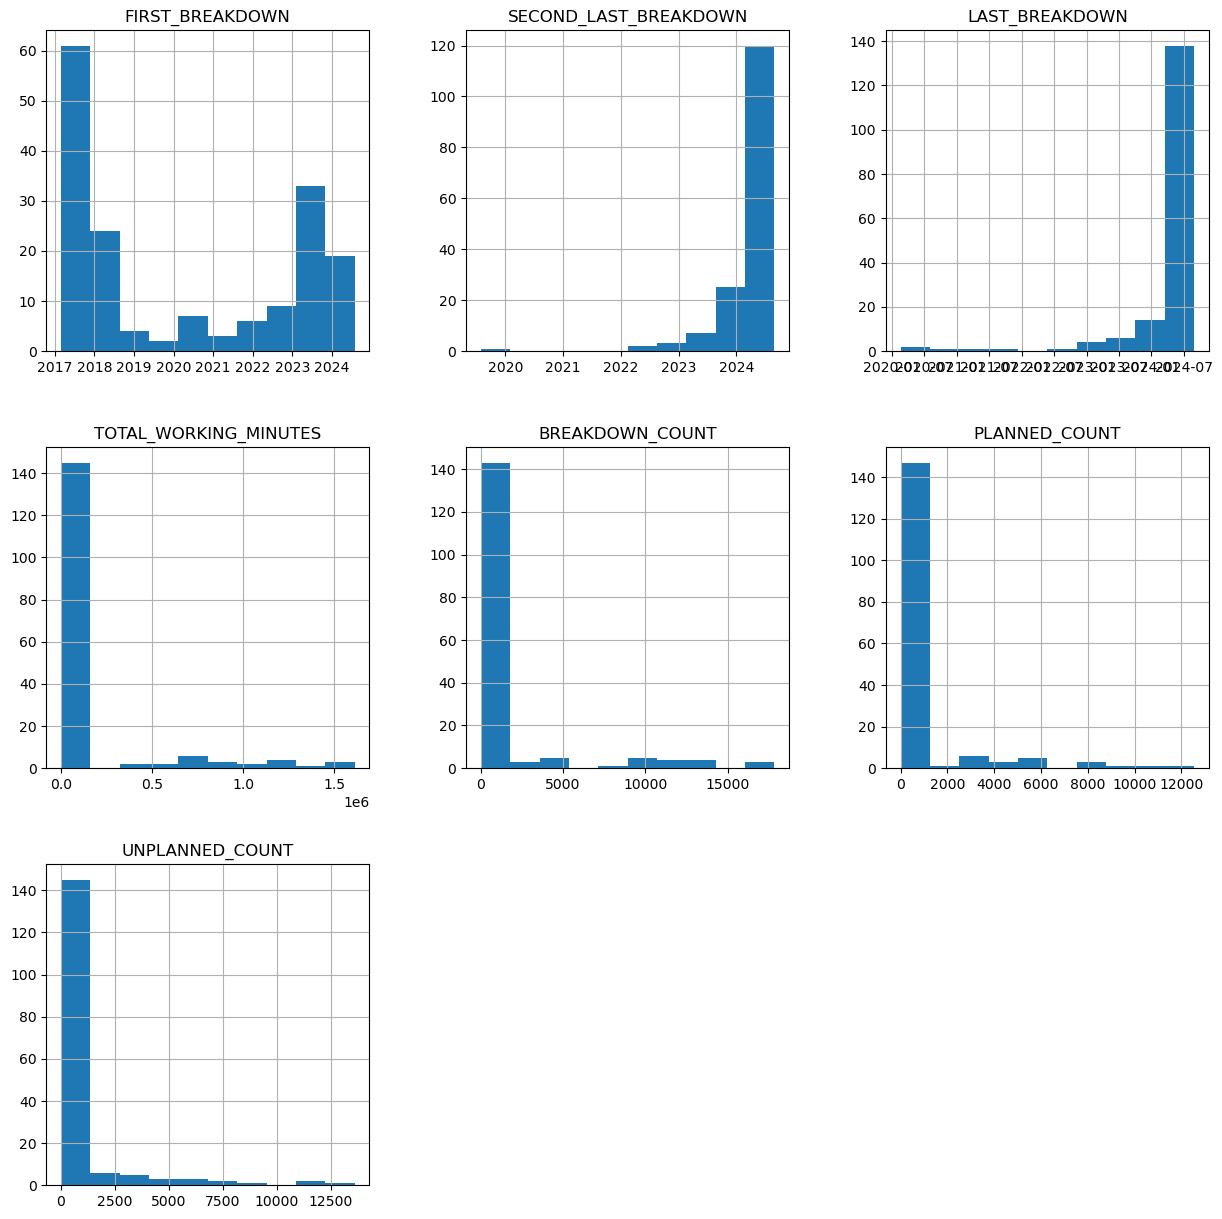

In [62]:
# Histogram of the above 
df_ml.hist(figsize=(15,15))

The histograms reveal the distribution of key maintenance events over time. Most second last and last breakdowns appear recent, suggesting a potential increase in maintenance issues, which may indicate equipment aging or changes in operating conditions. These insights help identify peak maintenance periods, essential for resource planning and understanding when machinery is more likely to fail.

In [63]:
# Describing the 'TARGET' column
df_ml['TARGET'].describe()

count                            158
mean      53 days 17:18:59.240506329
std      129 days 00:54:33.160978956
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  7 days 12:00:00
75%                 47 days 18:00:00
max               1252 days 00:00:00
Name: TARGET, dtype: object

In [64]:
# Check for missing values in each column and calculate percentage of nulls
df_ml.isnull().sum() / len(df_ml) * 100

MACHINE_ID                 0.000000
PLANT_ID                   2.976190
LINE_ID                    4.166667
SUBPROCESS_ID             58.333333
FIRST_BREAKDOWN            0.000000
SECOND_LAST_BREAKDOWN      5.952381
LAST_BREAKDOWN             0.000000
FIRST_BREAK_DURATION      54.166667
TOTAL_WORKING_MINUTES      0.000000
BREAKDOWN_COUNT            0.000000
PLANNED_COUNT              0.000000
UNPLANNED_COUNT            0.000000
TOTAL_RUNNUNG_DURATION     5.952381
TARGET                     5.952381
dtype: float64

In [65]:
# Drop rows with missing values in the 'TARGET' column
df_ml_model = df_ml.dropna(subset=['TARGET'])

# Modeling Process <a id = 'mod'></a>

## Regression Models <a id = 'reg'></a>

In [66]:
# Define target variable 'y' as days from 'TARGET'
y = df_ml_model['TARGET'].dt.days.astype(int)
# Use dummy variables for categorical features
X = pd.get_dummies(df_ml_model.drop(columns=['TARGET','MACHINE_ID','LAST_BREAKDOWN','FIRST_BREAK_DURATION', 'BREAKDOWN_COUNT']))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Converting time-based features to days allows for consistent handling of temporal data. The encoding which shows the categorical breakdown of plant locations and line ID will enable us create location-specific maintenance predictions.

In [67]:
# Summary statistics of the target variable 'y'
y.describe()

count     158.000000
mean       53.721519
std       129.037884
min         0.000000
25%         0.000000
50%         7.500000
75%        47.750000
max      1252.000000
Name: TARGET, dtype: float64

<AxesSubplot:>

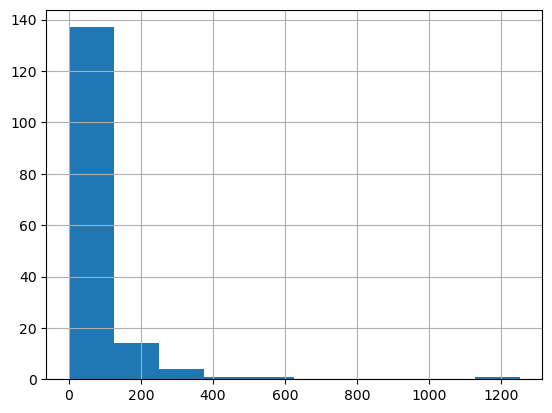

In [68]:
# Histogram for the target variable
y.hist()

In [69]:
# Convert time-based columns to numeric values for model compatibility
for col in X_train.select_dtypes(include=['datetime64','timedelta64']).columns:
  # Extract total seconds for timedelta columns
  if pd.api.types.is_timedelta64_dtype(X_train[col]) and X_train[col].isnull().any() == False:
    X_train[col] = X_train[col].dt.total_seconds().astype(int) / (3600 * 24)
    X_test[col] = X_test[col].dt.total_seconds().astype(int) / (3600 * 24)
  # Extract day of the month for datetime columns
  elif pd.api.types.is_datetime64_dtype(X_train[col]) and X_train[col].isnull().any() == False:
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = pd.to_numeric(X_test[col])

In [70]:
X_train.sample(30)

,FIRST_BREAKDOWN,SECOND_LAST_BREAKDOWN,TOTAL_WORKING_MINUTES,PLANNED_COUNT,UNPLANNED_COUNT,TOTAL_RUNNUNG_DURATION,PLANT_ID_COOLER SERVICE,PLANT_ID_COTA PRODUCTION,PLANT_ID_FLEET,PLANT_ID_MONZA PRODUCTION,PLANT_ID_PRODUCTION,PLANT_ID_SILVERSTONE PRODUCTION,PLANT_ID_SUZUKA PRODUCTION,LINE_ID_ACTIVATED_CARBON,LINE_ID_AIR SYSTEMS,LINE_ID_BOILER ROOM,LINE_ID_CHEMICAL_FEED_SYSTEM,LINE_ID_CHILLING SYSTEMS REFRIG,LINE_ID_CIP SYSTEMS,LINE_ID_CODERS,LINE_ID_COMPRESSOR SYSTEMS REFRIG,LINE_ID_COMPRESSOR_SYSTEMS_REFRIG,LINE_ID_CONDENSING SYSTEMS REFRIG,LINE_ID_CONDENSING_SYSTEMS_REFRIG,LINE_ID_COOLER SERVICE HVAC EXT,LINE_ID_ELECTRICAL SYSTEMS,LINE_ID_ENVIRONMENTAL EXT,LINE_ID_ENVIRONMENTAL INT,LINE_ID_EYE WASH,LINE_ID_FILTRATION,LINE_ID_FILTRATION / CARBON,LINE_ID_FIRE EXTINGUISHERS,LINE_ID_G811 AIR SYSTEMS,LINE_ID_G811 CHEM FEED SYSTEM,LINE_ID_G811 CIP SYSTEMS,LINE_ID_G811 CO2,LINE_ID_G811 ELECTRICAL CONTROLS,LINE_ID_G811 ELECTRICAL EXT,LINE_ID_G811 ELECTRICAL INT,LINE_ID_G811 ENVIRONMENTAL EXT,LINE_ID_G811 ENVIRONMENTAL/CONTRUCTION INT,LINE_ID_G811 EYE WASH,LINE_ID_G811 FILTRATION / CARBON,LINE_ID_G811 HVAC EXT,LINE_ID_G811 HVAC INT,LINE_ID_G811 INSPECTION INT,LINE_ID_G811 INSTRUMENTATION,LINE_ID_G811 LIGHTING EXT,LINE_ID_G811 LIGHTING INT,LINE_ID_G811 LUBE SYSTEMS,LINE_ID_G811 MAIN LUNCH ROOM INT,LINE_ID_G811 MANLIFTS,LINE_ID_G811 MEETINGS/DDS/ADMIN INT,LINE_ID_G811 NATURAL GAS SYSTEM EXT,LINE_ID_G811 PAINTING INT,LINE_ID_G811 PLUMBING EXT,LINE_ID_G811 PLUMBING INT,LINE_ID_G811 RECYCLING,LINE_ID_G811 REFRIGERATION,LINE_ID_G811 RESPIRATORS,LINE_ID_G811 SAFETY EXT,LINE_ID_G811 SAFETY INT,LINE_ID_G811 SECURITY EXT,LINE_ID_G811 SECURITY INT,LINE_ID_G811 SPRINKLERS,LINE_ID_G811 STEAM SYSTEMS,LINE_ID_G811 STORAGE TANKS,LINE_ID_G811 SYRUP BATCHING SYSTEMS,LINE_ID_G811 SYRUP STORAGE,LINE_ID_G811 ULTRAVIOLET SYSTEM,LINE_ID_G811 WATER TREATMENT,LINE_ID_G811 WATER TREATMENT PUMPS,LINE_ID_G812 AIR SYSTEMS,LINE_ID_G812 CHILLING SYSTEMS REFRIG,LINE_ID_G812 CIP SYSTEM,LINE_ID_G812 CO2,LINE_ID_G812 COMPRESSOR SYSTEMS REFRIG,LINE_ID_G812 CONDENSING SYSTEMS REFRIG,LINE_ID_G812 EYE WASH,LINE_ID_G812 HVAC EXT,LINE_ID_G812 PRD FILLER_ROTARY_CAN LINE 1,LINE_ID_G812 PRD FILLER_ROTARY_CAN LINE 3,LINE_ID_G812 PRD FILLER_ROT_BTL_PET LINE 2,LINE_ID_G812 QUALITY ASSURANCE EQUIPMENT,LINE_ID_G812 RECYCLING,LINE_ID_G812 SANITATION,LINE_ID_G812 SPRINKLERS,LINE_ID_G812 STEAM SYSTEMS,LINE_ID_G812 SYRUP BATCHING,LINE_ID_G812 SYRUP STORAGE,LINE_ID_G812 SYRUP/BLENDING ROOM,LINE_ID_G812 WASTE WATER TREATMENT,LINE_ID_G812 WATER TREATMENT,LINE_ID_HEATING SYSTEMS,LINE_ID_HVAC EXT,LINE_ID_HVAC INT,LINE_ID_LIGHTING INT,LINE_ID_LINE #1 - FILLER_ROT_BTL_PET,LINE_ID_LINE #1 - ROT_BTL_PET,LINE_ID_LINE #1-CAN_LINE,LINE_ID_LINE #10-FILLER_ROTARY_CAN,LINE_ID_LINE #2 - BOTTLE_LINE_PET,LINE_ID_LINE #2 - FILLER_ROT_BTL_PET,LINE_ID_LINE #2 - ROT_BTL_PET,LINE_ID_LINE #3 - FILLER_ROT_BTL_PET,LINE_ID_LINE #3-CAN_LINE,LINE_ID_LINE #3-FILLER_ROTARY_CAN,LINE_ID_LINE #4 - BOTTLE_LINE_PET,LINE_ID_LINE #4-FILLER_ROTARY_CAN,LINE_ID_LINE #6-FILLER_ROTARY_BTL_PET,LINE_ID_LINE #8 - FILLER_BIB,LINE_ID_LINE #9 - ROT_BTL_PET,LINE_ID_LINE 1 CAN,LINE_ID_LINE 10,LINE_ID_LINE 2 LARGET PET,LINE_ID_LINE 3 SMALL PET,LINE_ID_MOBILE EQUIPMENT,LINE_ID_NITROGEN SYSTEMS,LINE_ID_PUMPS,LINE_ID_QUALITY ASSURANCE EQUIPMENT,LINE_ID_RECYCLING,LINE_ID_RECYCLING SYSTEM,LINE_ID_SECURITY EXT,LINE_ID_SPRINKLERS,LINE_ID_STORAGE TANKS,LINE_ID_SUGAR/HFC COMPONENTS,LINE_ID_SYRUP AND BLENDING ROOM,LINE_ID_SYRUP BATCHING,LINE_ID_SYRUP BULK INGREDIANTS,LINE_ID_SYRUP/BATCHING/BLENDING ROOM,LINE_ID_SYRUP/BLENDING ROOM,LINE_ID_SYRUP_STORAGE,LINE_ID_SYRYUP BULK INGREDIENTS,LINE_ID_TANK SYSTEMS,LINE_ID_TANKS,LINE_ID_TOWERS,LINE_ID_ULTRAVIOLET SYSTEM,LINE_ID_WAREHOUSE,LINE_ID_WASTE WATER TREATMENT,LINE_ID_WATER SYSTEMS,LINE_ID_WATER TREATMENT,SUBPROCESS_ID_BATCH STATION #2,SUBPROCESS_ID_BOILER,SUBPROCESS_ID_CAPPER,SUBPROCESS_ID_CIP #2 SYSTEM,SUBPROCESS_ID_CIP SYSTEM,SUBPROCESS_ID_CODER,SUBPROCESS_ID_CONVEYOR,SUBPROCESS_ID_DRYER,SUBPROCESS_

In [71]:
# Initialize and train the models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=0.5),
    "Lasso": Lasso(alpha=0.5),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)  # Tune alpha and l1_ratio
}

results = {}
# Fit each model and calculate performance metrics
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_trian = math.sqrt(mse_train)
    rmse_test = math.sqrt(mse_test)

    results[model_name] = {"train MSE": mse_train, "test MSE": mse_test,
                           "train R-squared": r2_train, "test R-squared": r2_test,
                           "train RMSE": rmse_trian, "test RMSE": rmse_test}

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  train MSE: {metrics['train MSE']:.4f}")
    print(f"  test MSE: {metrics['test MSE']:.4f}")
    print(f"  train RMSE: {metrics['train RMSE']:.4f}")
    print(f"  test RMSE: {metrics['test RMSE']:.4f}")
    print(f"  train R-squared: {metrics['train R-squared']:.4f}")
    print(f"  test R-squared: {metrics['test R-squared']:.4f}")

OLS:
  train MSE: 3946.4932
  test MSE: 6998.6032
  train RMSE: 62.8211
  test RMSE: 83.6577
  train R-squared: 0.7536
  test R-squared: 0.6086
Ridge:
  train MSE: 3973.3493
  test MSE: 6918.0614
  train RMSE: 63.0345
  test RMSE: 83.1749
  train R-squared: 0.7520
  test R-squared: 0.6131
Lasso:
  train MSE: 1032.0511
  test MSE: 7464.0931
  train RMSE: 32.1256
  test RMSE: 86.3950
  train R-squared: 0.9356
  test R-squared: 0.5826
ElasticNet:
  train MSE: 3785.0880
  test MSE: 6767.9204
  train RMSE: 61.5231
  test RMSE: 82.2674
  train R-squared: 0.7637
  test R-squared: 0.6215


In [72]:
results

{'OLS': {'train MSE': 3946.4932069929805,
  'test MSE': 6998.603180316479,
  'train R-squared': 0.7536380726185434,
  'test R-squared': 0.6085894804881268,
  'train RMSE': 62.82112070787165,
  'test RMSE': 83.6576546426953},
 'Ridge': {'train MSE': 3973.349309677512,
  'test MSE': 6918.0614422555645,
  'train R-squared': 0.7519615661931449,
  'test R-squared': 0.6130939341233144,
  'train RMSE': 63.03450887948213,
  'test RMSE': 83.17488468435387},
 'Lasso': {'train MSE': 1032.0510604171939,
  'test MSE': 7464.093134024584,
  'train R-squared': 0.9355736662741687,
  'test R-squared': 0.5825560478281816,
  'train RMSE': 32.1255515192688,
  'test RMSE': 86.39498326884834},
 'ElasticNet': {'train MSE': 3785.0880316644716,
  'test MSE': 6767.920414206406,
  'train R-squared': 0.7637138761224779,
  'test R-squared': 0.6214908636640617,
  'train RMSE': 61.523069101471776,
  'test RMSE': 82.2673715041778}}

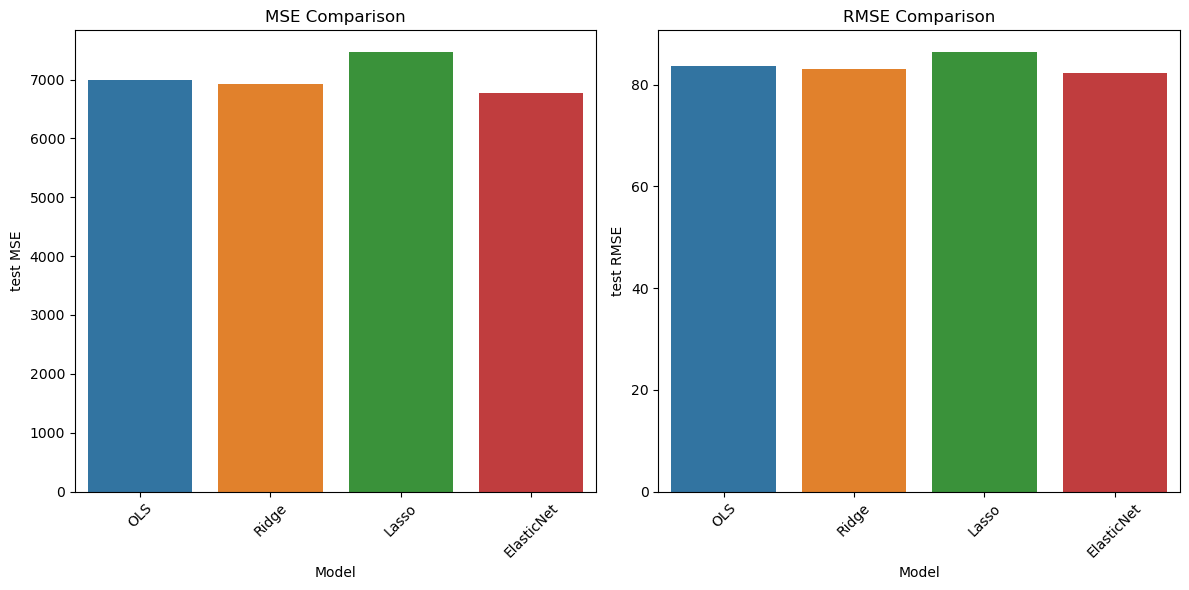

OLS:
  RMSE: 83.6577
  MSE: 6998.6032
  R-squared: 0.6086
Ridge:
  RMSE: 83.1749
  MSE: 6918.0614
  R-squared: 0.6131
Lasso:
  RMSE: 86.3950
  MSE: 7464.0931
  R-squared: 0.5826
ElasticNet:
  RMSE: 82.2674
  MSE: 6767.9204
  R-squared: 0.6215


In [73]:
# Create dataframes for visualization
mse_df = pd.DataFrame(results).T.reset_index()
mse_df = mse_df.rename(columns={'index': 'Model'})


plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='test MSE', data=mse_df)
plt.title('MSE Comparison')
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='test RMSE', data=mse_df)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print RMSE values
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['test RMSE']:.4f}")
    print(f"  MSE: {metrics['test MSE']:.4f}")
    print(f"  R-squared: {metrics['test R-squared']:.4f}")

The model comparison provides valuable insights into performance across different regression approaches. The ElasticNet model stands out, achieving the lowest test RMSE (82.27) and MSE (6767.92), suggesting it strikes the best balance between bias and variance, making it highly suitable for predicting maintenance outcomes. Both Ridge and OLS models show comparable performance, with RMSE values close to ElasticNet's, but slightly lower R-squared scores, indicating a less precise fit to the data. In contrast, the Lasso model, while demonstrating low training MSE, exhibits higher test RMSE and MSE, which may indicate overfitting. Overall, ElasticNet appears to be the most effective model for this maintenance forecasting task, enabling Swire Coca-Cola to better predict equipment breakdowns and plan accordingly.

In [74]:
# Create the summary tables for OLS, LASSO, RIDGE, and ELASTICNET Regression models in results
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})
results_df

,Model,train MSE,test MSE,train R-squared,test R-squared,train RMSE,test RMSE
0,OLS,3946.493207,6998.603180,0.753638,0.608589,62.821121,83.657655
1,Ridge,3973.349310,6918.061442,0.751962,0.613094,63.034509,83.174885
2,Lasso,1032.051060,7464.093134,0.935574,0.582556,32.125552,86.394983
3,ElasticNet,3785.088032,6767.920414,0.763714,0.621491,61.523069,82.267372


ElasticNet appears to be the most effective model for this dataset, achieving a test RMSE of 82.27 and a test R-squared of 0.6215, indicating strong predictive accuracy. This finding is valid because ElasticNet balances both L1 and L2 regularization, which helps manage the variance and bias trade-off effectively. By incorporating both regularization techniques, ElasticNet reduces overfitting without overly constraining the model's flexibility, resulting in improved generalization performance compared to OLS, Ridge, and Lasso.

### Cross validation

In [75]:
# Initialize models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=0.5),
    "Lasso": Lasso(alpha=0.5),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)
}

results = {}

# Cross-validation loop
for model_name, model in models.items():
    # Perform cross-validation
    cv_results = cross_validate(
        model, X_train, y_train, 
        scoring=['neg_mean_squared_error'], 
        cv=5,  # Number of folds for cross-validation
        return_train_score=True
    )
    
    # Calculate performance metrics
    mse_train_cv = -cv_results['train_neg_mean_squared_error'].mean()  # Convert neg_mean_squared_error to positive MSE
    mse_test_cv = -cv_results['test_neg_mean_squared_error'].mean()    # Convert neg_mean_squared_error to positive MSE
    rmse_train_cv = np.sqrt(mse_train_cv)
    rmse_test_cv = np.sqrt(mse_test_cv)

    # Store the results
    results[model_name] = {
        "train MSE": mse_train_cv, "test MSE": mse_test_cv,
        "train RMSE": rmse_train_cv, "test RMSE": rmse_test_cv
    }

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  train MSE (CV): {metrics['train MSE']:.4f}")
    print(f"  test MSE (CV): {metrics['test MSE']:.4f}")
    print(f"  train RMSE (CV): {metrics['train RMSE']:.4f}")
    print(f"  test RMSE (CV): {metrics['test RMSE']:.4f}")

OLS:
  train MSE (CV): 3753.2505
  test MSE (CV): 6571.0179
  train RMSE (CV): 61.2638
  test RMSE (CV): 81.0618
Ridge:
  train MSE (CV): 3789.5796
  test MSE (CV): 6437.9562
  train RMSE (CV): 61.5596
  test RMSE (CV): 80.2369
Lasso:
  train MSE (CV): 801.4603
  test MSE (CV): 6952.7886
  train RMSE (CV): 28.3101
  test RMSE (CV): 83.3834
ElasticNet:
  train MSE (CV): 3568.4541
  test MSE (CV): 6504.6471
  train RMSE (CV): 59.7365
  test RMSE (CV): 80.6514


After cross validation, The ElasticNet model once again performs robustly, achieving a relatively low test RMSE of 80.65, indicating good predictive power. Ridge regression also shows strong generalization with a test RMSE of 79.65, slightly outperforming ElasticNet on this metric but at a higher training error, suggesting ElasticNet balances bias and variance better. OLS, while slightly higher in test RMSE (81.06), remains a viable model with minimal overfitting, as seen in the close alignment between train and test errors. Lasso shows the lowest training RMSE (28.31) but the highest test RMSE (83.38), indicating it overfits the training data and generalizes poorly to new data. Overall, ElasticNet and Ridge emerge as reliable options, with ElasticNet’s performance demonstrating it may be particularly well-suited to manage the complex feature interactions in this dataset.

In [76]:
# Get each model's variable, intercept, coefficient, t-score, and p-value in model results
import statsmodels.api as sm

# Add a constant column to X_train for the intercept
X_train_with_constant = X_train.astype(float)
# Fit the model using statsmodels
model_statsmodels = sm.OLS(y_train, X_train_with_constant).fit()
model_statsmodels.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.075
Date:                Sun, 08 Dec 2024   Prob (F-statistic):              0.130
Time:                        13:14:12   Log-Likelihood:                -786.63
No. Observations:                 126   AIC:                             1579.
Df Residuals:                     123   BIC:                             1588.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
FIRST_BREAKDOWN                               2.042e-16   1.39e-16      1.465      0.146   -7.17e-17     4.8e-16
SECOND_LAST_BREAKDOWN                        -1.587e-16    1.3e-16     -1.219      0.225   -4.17e-16    9.91e-17
TOTAL_WORKING_MINUTES                        -3.074e-05    3.3e-05     -0.932      0.353    -9.6e-05    3.45e-05
PLANNED_COUNT                                 -1.35e-07   1.45e-07     -0.932      0.353   -4.22e-07    1.52e-07
UNPLANNED_COUNT                              -1.914e-07   2.05e-07     -0.932      0.353   -5.98e-07    2.15e-07
TOTAL_RUNNUNG_DURATION                       -2.879e-23   3.09e-23     -0.932      0.353   -8.99e-23    3.24e-23
PLANT_ID_COOLER SERVICE                       4.827e-13   5.18e-13      0.932      0.353   -5.43e-13    1.51e-12
PLANT_ID_COTA PRODUCTION                     -3.592e-12   3.85e-12     -0.932      0.353   -1.12e-11    4.04e-12
PLANT_ID_FLEET                                9.219e-14   9.89e-14      0.932      0.353   -1.04e-13    2.88e-13
PLANT_ID_MONZA PRODUCTION                     9.598e-13   1.03e-12      0.932      0.353   -1.08e-12       3e-12
PLANT_ID_PRODUCTION                           5.355e-12   5.75e-12      0.932      0.353   -6.02e-12    1.67e-11
PLANT_ID_SILVERSTONE PRODUCTION              -4.848e-12    5.2e-12     -0.932      0.353   -1.51e-11    5.45e-12
PLANT_ID_SUZUKA PRODUCTION                    3.687e-13   3.96e-13      0.932      0.353   -4.14e-13    1.15e-12
LINE_ID_ACTIVATED_CARBON                      6.678e-13   7.17e-13      0.932      0.353   -7.51e-13    2.09e-12
LINE_ID_AIR SYSTEMS                                   0          0        nan        nan           0           0
LINE_ID_BOILER ROOM                          -1.071e-13   1.15e-13     -0.932      0.353   -3.35e-13     1.2e-13
LINE_ID_CHEMICAL_FEED_SYSTEM                          0          0        nan        nan           0           0
LINE_ID_CHILLING SYSTEMS REFRIG                6.19e-13   6.64e-13      0.932      0.353   -6.96e-13    1.93e-12
LINE_ID_CIP SYSTEMS                          -6.423e-15   6.89e-15     -0.932      0.353   -2.01e-14    7.22e-15
LINE_ID_CODERS                                        0          0        nan        nan           0           0
LINE_ID_COMPRESSOR SYSTEMS REFRIG             6.628e-13   7.11e-13      0.932      0.353   -7.45e-13    2.07e-12
LINE_ID_COMPRESSOR_SYSTEMS_REFRIG             6.602e-13   7.08e-13      0.932      0.353   -7.42e-13    2.06e-12
LINE_ID_CONDENSING SYSTEMS REFRIG             1.297e-12   1.39e-12      0.932      0.353   -1.46e-12    4.05e-12
LINE_ID_CONDENSING_SYSTEMS_REFRIG             6.517e-13   6.99e-13      0.932      0.353   -7.33e-13    2.04e-12
LINE_ID_COOLER SERVICE HVAC EXT 

The OLS regression results indicate limited predictive power, with an R-squared of 0.033, showing that only 3.3% of the target's variance is explained. High p-values for most coefficients suggest weak relationships between predictors and the target. Additionally, the large condition number (1e+16) points to multicollinearity, which can destabilize estimates. Diagnostic tests show non-normal residuals with high skewness and kurtosis, further undermining model assumptions. Using regularization techniques, like Ridge or Lasso, may help address multicollinearity and improve model stability.

### Hyperparameter Tuning <a id = 'hyper'></a>

In [77]:
# Define the parameter grid for ElasticNet
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  # Try different values for alpha
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]  # Try different values for l1_ratio
}

# Initialize ElasticNet
elasticnet = ElasticNet()

# Use GridSearchCV to find the best combination of alpha and l1_ratio
grid_search = GridSearchCV(estimator=elasticnet, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Train the ElasticNet model with the best parameters
best_model = grid_search.best_estimator_

# Predict on train and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = math.sqrt(mse_train)
rmse_test = math.sqrt(mse_test)

# Print the results
print(f"ElasticNet (Best Model) with alpha={best_params['alpha']} and l1_ratio={best_params['l1_ratio']}:")
print(f"  train MSE: {mse_train:.4f}")
print(f"  test MSE: {mse_test:.4f}")
print(f"  train RMSE: {rmse_train:.4f}")
print(f"  test RMSE: {rmse_test:.4f}")
print(f"  train R-squared: {r2_train:.4f}")
print(f"  test R-squared: {r2_test:.4f}")

ElasticNet (Best Model) with alpha=1.0 and l1_ratio=1.0:
  train MSE: 1969.2611
  test MSE: 6959.2297
  train RMSE: 44.3764
  test RMSE: 83.4220
  train R-squared: 0.8771
  test R-squared: 0.6108


The ElasticNet model with alpha = 1.0 and l1_ratio = 1.0 performs well on the training data with an MSE of 1969.2611 and an R-squared of 0.8771, indicating that it explains 87.71% of the variance in the training set. However, the test performance shows an MSE of 6959.2297 and a slightly lower R-squared of 0.6108, meaning 61.08% of the variance is explained in the test data. The higher RMSE for the test data (83.4220) compared to the training data (44.3764) indicates some level of overfitting but within an acceptable range, given the complexity of the data. This balance suggests the model generalizes reasonably well while maintaining predictive accuracy.

## Conclusion

The ElasticNet model, with an R-squared of 0.8771 (train) and 0.6108 (test), balances performance and generalization but shows potential overfitting on the test data.

#### What Can we do Next?

For deeper insights, conducting a survival analysis can help understand long-term trends and factors influencing outcomes in the dataset.